This simulation aims to model a three-lane road with heterogeneous vehicles.   

Road features
The road has a PUV lane for jeepneys and minibuses. The rightmost lane is the PUV lane. "Lanes" should not be confused with "cell rows". One lane is two cells wide. In this simulation, 
the road has 3 lanes, and hence, 6 cells wide. An additional 1-cell row is added to serve as a pedestrian holding area for passengers waiting for a ride to public utility vehicles.

Boundary conditions
Vehicles appear on the beginning of the road on a certain probability. When it reaches the end, it disappears.

Vehicles and its behavior

1. Cars (2x2) - Confined to the two lanes together with trucks and motorcycles. Capable of lane changing.
2. Motorcycles (1x1) - Confined to the two lanes together with trucks and cars. Capable of lane changing.
3. Trucks(7x2) - Confined to the two lanes together with cars and motorcycles. Capable of lane changing.

4. Jeep (3x2) - Public Utility vehicle. Confined in the PUV lane with minibuses. Cannot change lane. This vehicle makes sudden stops to load/unload passengers.
5. Minibuses (4x2) - Public Utility vehicle. Confined in the PUV lane with minibuses. Cannot change lane. This vehicle makes sudden stops to load/unload passengers.

Passenger Count per Vehicle
We define passenger as an individual that needs to ride a specific mode of transportation to move from one place to another. Truck drivers and conductors are not counted as passengers. Passengers also include PUVs, car and motorcycle drivers. 

1. Cars(can accomodate 1-5 passengers)
2. Motorcycles(can accomodate 1-2 passengers)
3. Trucks(0 passengers, load mainly for commercial purposes)
4. Jeep (can accomodate 20-25 passengers)'
5. Minibuses(can accomodate (25-27 passengers)

Let's start with the case of no lane changing on non-PUV lanes.

In [17]:
import numpy as np
import matplotlib.pyplot as plt

In [18]:
class Vehicle:
    def __init__(self, x_position, speed, max_speed, length, width, road_designation, vehicle_type, current_lane, lane_changing_prob):
        self.x_position = x_position #position along the length of the road (x position)
        self.speed = speed #number of cells the vehicle will move per timestep
        self.max_speed = max_speed #maximum speed
        self.braking_prob = 0.01 #probability of random slowdown
        self.length = length #length of the vehicle is the number of cells the vehicle occupies along the length of the road
        self.width = width #width of the vehicle is the number of cells the vehicle occupies along the width of the road
        self.road_designation = road_designation #the road where the vehicle is currently located
        self.vehicle_type = vehicle_type #type of vehicle is determined by the size and behavior
        self.current_lane = current_lane #also known as the y position of the left side of the vehicle
        self.lane_changing_prob = lane_changing_prob
        
    def accelerate(self): 
        """Increases vehicle's speed by 1 cell, up to the maximum speed"""
        if self.speed < self.max_speed:
            self.speed += 1 

    def decelerate(self, gap_distance):
        """decreases vehicle's speed to match the gap distance, given the speed>gap distance"""
        if self.speed > gap_distance:
            self.speed = gap_distance #the gap distance is the distance between follower vehicle front bumper and leading vehicle rear bumper
            
    def randomize(self, braking_prob):
        """Mimics random slowdown, randomly decreases vehicle's speed based on braking probability """
        if np.random.rand() < self.braking_prob:
            if self.speed > 0:
                self.speed -= 1

    def lane_changing(self):
        """attempts to change lanes based on vehicle type and lane availability"""
        #Here, we define a lane as a space of 2 cells wide. We assume a three-lane road(6 cells wide, with 1 cell wide passenger holding area beside)
        #we assume that each half lane is an array, imagine a vertical stack of arrays, indexing is from top to bottom. Right side is the bottom.
        if np.random.rand() < self.lane_changing_prob: #provide here a mechanism that checks the other lanes before lane changing(IT IS AN IMPERATIVE TO DO THAT) --- DONE
            new_lane = self.current_lane
            if self.vehicle_type in ['car', 'truck']:
                if self.current_lane < self.road_designation.road_width - 5: #This is slightly hardcoded. 
                        new_lane = self.current_lane + 1 #if on lanes 0 and 1
                elif self.current_lane < self.road_designation.road_width - 4 and self.current_lane > 0: #This is slightly hardcoded. 
                        new_lane = self.current_lane - 1 #if on lanes 1, 2
            if self.vehicle_type in ['motorcycle']: 
                if self.current_lane < self.road_designation.road_width - 4:
                        new_lane = self.current_lane + 1 #if on lanes 0-2
                elif self.current_lane < self.road_designation.road_width - 3 and self.current_lane > 0: #This is slightly hardcoded. 
                        new_lane = self.current_lane - 1 #if on lanes 1-3
            #Check for space on the lane of interest
            if self.road_designation.road_occupancy[self.x_position+self.length, new_lane] == 0: #This is slightly hardcoded. 
                self.current_lane = new_lane

In [19]:
class Road:
    def __init__(self, road_length, road_width, speed_limit):
        self.road_length = road_length
        self.road_width = road_width
        self.speed_limit = speed_limit
        self.road_occupancy = np.zeros((road_length, road_width)) #note that this road is vertical when printed/visualized

In [20]:
class IntraRoadSimulator:
    def __init__(self, road):
        """This method stores the necessary information to move the vehicles in a given space(road)"""
        self.road = road #this class demands an input road
        self.car_production_prob = 0.4
        self.jeep_production_prob = 0.7
        self.minibus_production_prob = 0.3
        self.truck_production_prob = 0.3
        self.motor_production_prob = 0.3
        self.vehicles = [] #collection of vehicles on the road
        self.occupancy_history = [] #initializes an empty array to store the road configuration for visualization purposes

    def update_occupancy(self):
        """This method updates road occupancy. Occupied is 1, while empty is 0"""
        self.road.road_occupancy.fill(0) #clears the occupancy information from the previous timestep. One road occupancy array is good for one timestep.
        for vehicle in self.vehicles: #updates occupancy for all vehicles
            if vehicle.x_position < self.road.road_length - 1: #check if the position of the vehicle does not exceed road bounds
                #The following details the rear and front bumper of a vehicle
                x_start = vehicle.x_position #location of the rear bumper
                x_end = min(vehicle.x_position + vehicle.length, self.road.road_length) #location of the front bumper
                y_start = vehicle.current_lane #left side of the vehicle
                y_end = min(vehicle.current_lane + vehicle.width, self.road.road_width)#right side of the vehicle
                self.road.road_occupancy[x_start:x_end, y_start:y_end] = 1 #Declare the occupied cells. Note that x_end and y_end are not inclusive of the range.
        self.occupancy_history.append(self.road.road_occupancy.copy()) #stores the occupancy per iteration

    def produce_PUV(self):
        """Produce a public utility vehicle and place it on the road"""
        vehicle_type = None
        vehicle_length = 0
        vehicle_width = 0
        current_lane = 0
        lane_changing_prob = 0

        #Define PUV lane
        PUV_lane = 4

        if np.random.rand() < self.jeep_production_prob:
            vehicle_type = 'jeep'
            vehicle_length = 3
            vehicle_width = 2
            current_lane = PUV_lane #special lane
            lane_changing_prob = 0
        elif np.random.rand() < self.minibus_production_prob:
            vehicle_type = 'minibus'
            vehicle_length = 4
            vehicle_width = 2
            current_lane = PUV_lane #special lane
            lane_changing_prob = 0
        else:
            #no vehicle produced this time step
            return
        
        # Check if there is space for the vehicle on the lane
        road_portion_checked = self.road.road_occupancy[0:vehicle_length, PUV_lane:PUV_lane + vehicle_width]
        if np.sum(road_portion_checked) == 0: #checks if the start of the road is empty
            # Create a new vehicle and add it to the road
            new_vehicle_speed = np.random.randint(1, self.road.speed_limit + 1) 
            new_vehicle = Vehicle(0, new_vehicle_speed, self.road.speed_limit, vehicle_length, vehicle_width, self.road, vehicle_type, current_lane, lane_changing_prob) #facilitates spawning of vehicles
            self.vehicles.append(new_vehicle)
            # Update the road occupancy to include the new vehicle
            self.road.road_occupancy[0:new_vehicle.length, current_lane:current_lane + new_vehicle.width] = 1
        else:
            pass
    
    def produce_cars(self):
        vehicle_type = None
        vehicle_length = 0
        vehicle_width = 0
        current_lane = 0
        lane_changing_prob = 0

        if np.random.rand() < self.car_production_prob:
            vehicle_type = 'car'
            vehicle_length = 2
            vehicle_width = 2
            restricted_lanes = 4 #Note the current lane is the y position of the left(upper) part of the vehicle. Cars can only be at lanes 0-2
            current_lane = np.random.choice(range(0, self.road.road_width - restricted_lanes, 1)) #4 lanes restricted
            lane_changing_prob = 0.01
        else:
            #no vehicle produced this time step
            return

        #checks the start of the lanes
        car_lanes = range(4)
        for lane in car_lanes:
            road_portion_checked = self.road.road_occupancy[0:vehicle_length, lane:lane + vehicle_width]
            if np.sum(road_portion_checked) == 0: #checks if the start of the road is empty
                new_vehicle_speed = np.random.randint(1, self.road.speed_limit + 1) 
                new_vehicle = Vehicle(0, new_vehicle_speed, self.road.speed_limit, vehicle_length, vehicle_width, self.road, vehicle_type, current_lane, lane_changing_prob) #facilitates spawning of vehicles
                self.vehicles.append(new_vehicle)
                self.road.road_occupancy[0:new_vehicle.length, current_lane:current_lane + new_vehicle.width] = 1
            else:
                pass

    def produce_trucks(self):
        vehicle_type = None
        vehicle_length = 0
        vehicle_width = 0
        current_lane = 0
        lane_changing_prob = 0


        if np.random.rand() < self.truck_production_prob:
            vehicle_type = 'truck'
            vehicle_length = 7
            vehicle_width = 2
            restricted_lanes = 4 #trucks can only be at lanes 0-2
            current_lane = np.random.choice(range(0, self.road.road_width - restricted_lanes, 1)) #4 lanes restricted
            lane_changing_prob = 0.01
        else:
            #no vehicle produced this time step
            return

        #checks the start of the lanes
        truck_lanes = range(4)
        for lane in truck_lanes:
            road_portion_checked = self.road.road_occupancy[0:vehicle_length, lane:lane + vehicle_width]
            if np.sum(road_portion_checked) == 0: #checks if the start of the road is empty
                new_vehicle_speed = np.random.randint(1, self.road.speed_limit + 1) 
                new_vehicle = Vehicle(0, new_vehicle_speed, self.road.speed_limit, vehicle_length, vehicle_width, self.road, vehicle_type, current_lane, lane_changing_prob) #facilitates spawning of vehicles
                self.vehicles.append(new_vehicle)
                self.road.road_occupancy[0:new_vehicle.length, current_lane:current_lane + new_vehicle.width] = 1
            else:
                pass

        
    def produce_motor(self):
            vehicle_type = None
            vehicle_length = 0
            vehicle_width = 0
            current_lane = 0
            lane_changing_prob = 0
            
            if np.random.rand() < self.motor_production_prob:
                vehicle_type = 'motorcycle'
                vehicle_length = 1
                vehicle_width = 1
                restricted_lanes = 3 #motorcycles can only be at lanes 0-3
                current_lane = np.random.choice(range(0, self.road.road_width - restricted_lanes, 1)) #3 lanes restricted
                lane_changing_prob = 0.01
            else:
            #no vehicle produced this time step
                return

            #checks the start of the lanes
            motorcycle_lanes = range(5)
            for lane in motorcycle_lanes:
                road_portion_checked = self.road.road_occupancy[0:vehicle_length, lane:lane + vehicle_width]
                if np.sum(road_portion_checked) == 0: #checks if the start of the road is empty
                    new_vehicle_speed = np.random.randint(1, self.road.speed_limit + 1) 
                    new_vehicle = Vehicle(0, new_vehicle_speed, self.road.speed_limit, vehicle_length, vehicle_width, self.road, vehicle_type, current_lane, lane_changing_prob) #facilitates spawning of vehicles
                    self.vehicles.append(new_vehicle)
                    self.road.road_occupancy[0:new_vehicle.length, current_lane:current_lane + new_vehicle.width] = 1
                else:
                    pass

    def gap_distance(self, vehicle):
        """This method obtains the distance between the front bumper of the follower vehicle and the rear bumper of the leading vehicle"""
        current_x_position = vehicle.x_position #thisis the position of a vehicle's rear bumper
        maximum_possible_distance = self.road.road_length - current_x_position - vehicle.length #note that prospective x positions should also take account of the space of vehicle front
        for distance in range(1, maximum_possible_distance + 1):
            next_x_position = current_x_position + vehicle.length + distance
            if next_x_position >= self.road.road_length:
                return distance - 1
            if np.any(self.road.road_occupancy[next_x_position:vehicle.length, vehicle.current_lane:vehicle.width] == 1):
                return distance - 1 #SHOULD I  include MINUS 1 HERE???
        return maximum_possible_distance

    def update(self):
        self.produce_PUV()    
        self.produce_cars()
        self.produce_trucks()
        self.produce_motor()
        for vehicle in self.vehicles:
            distance_to_next = self.gap_distance(vehicle)
            vehicle.accelerate()
            vehicle.decelerate(distance_to_next)
            vehicle.randomize(vehicle.braking_prob)
            vehicle.x_position += vehicle.speed
            vehicle.lane_changing()
        
        self.vehicles = [vehicle for vehicle in self.vehicles if vehicle.x_position < self.road.road_length]  # Remove vehicles that have exited the road

        self.update_occupancy()

In [76]:
len(simulator.occupancy_history)

9

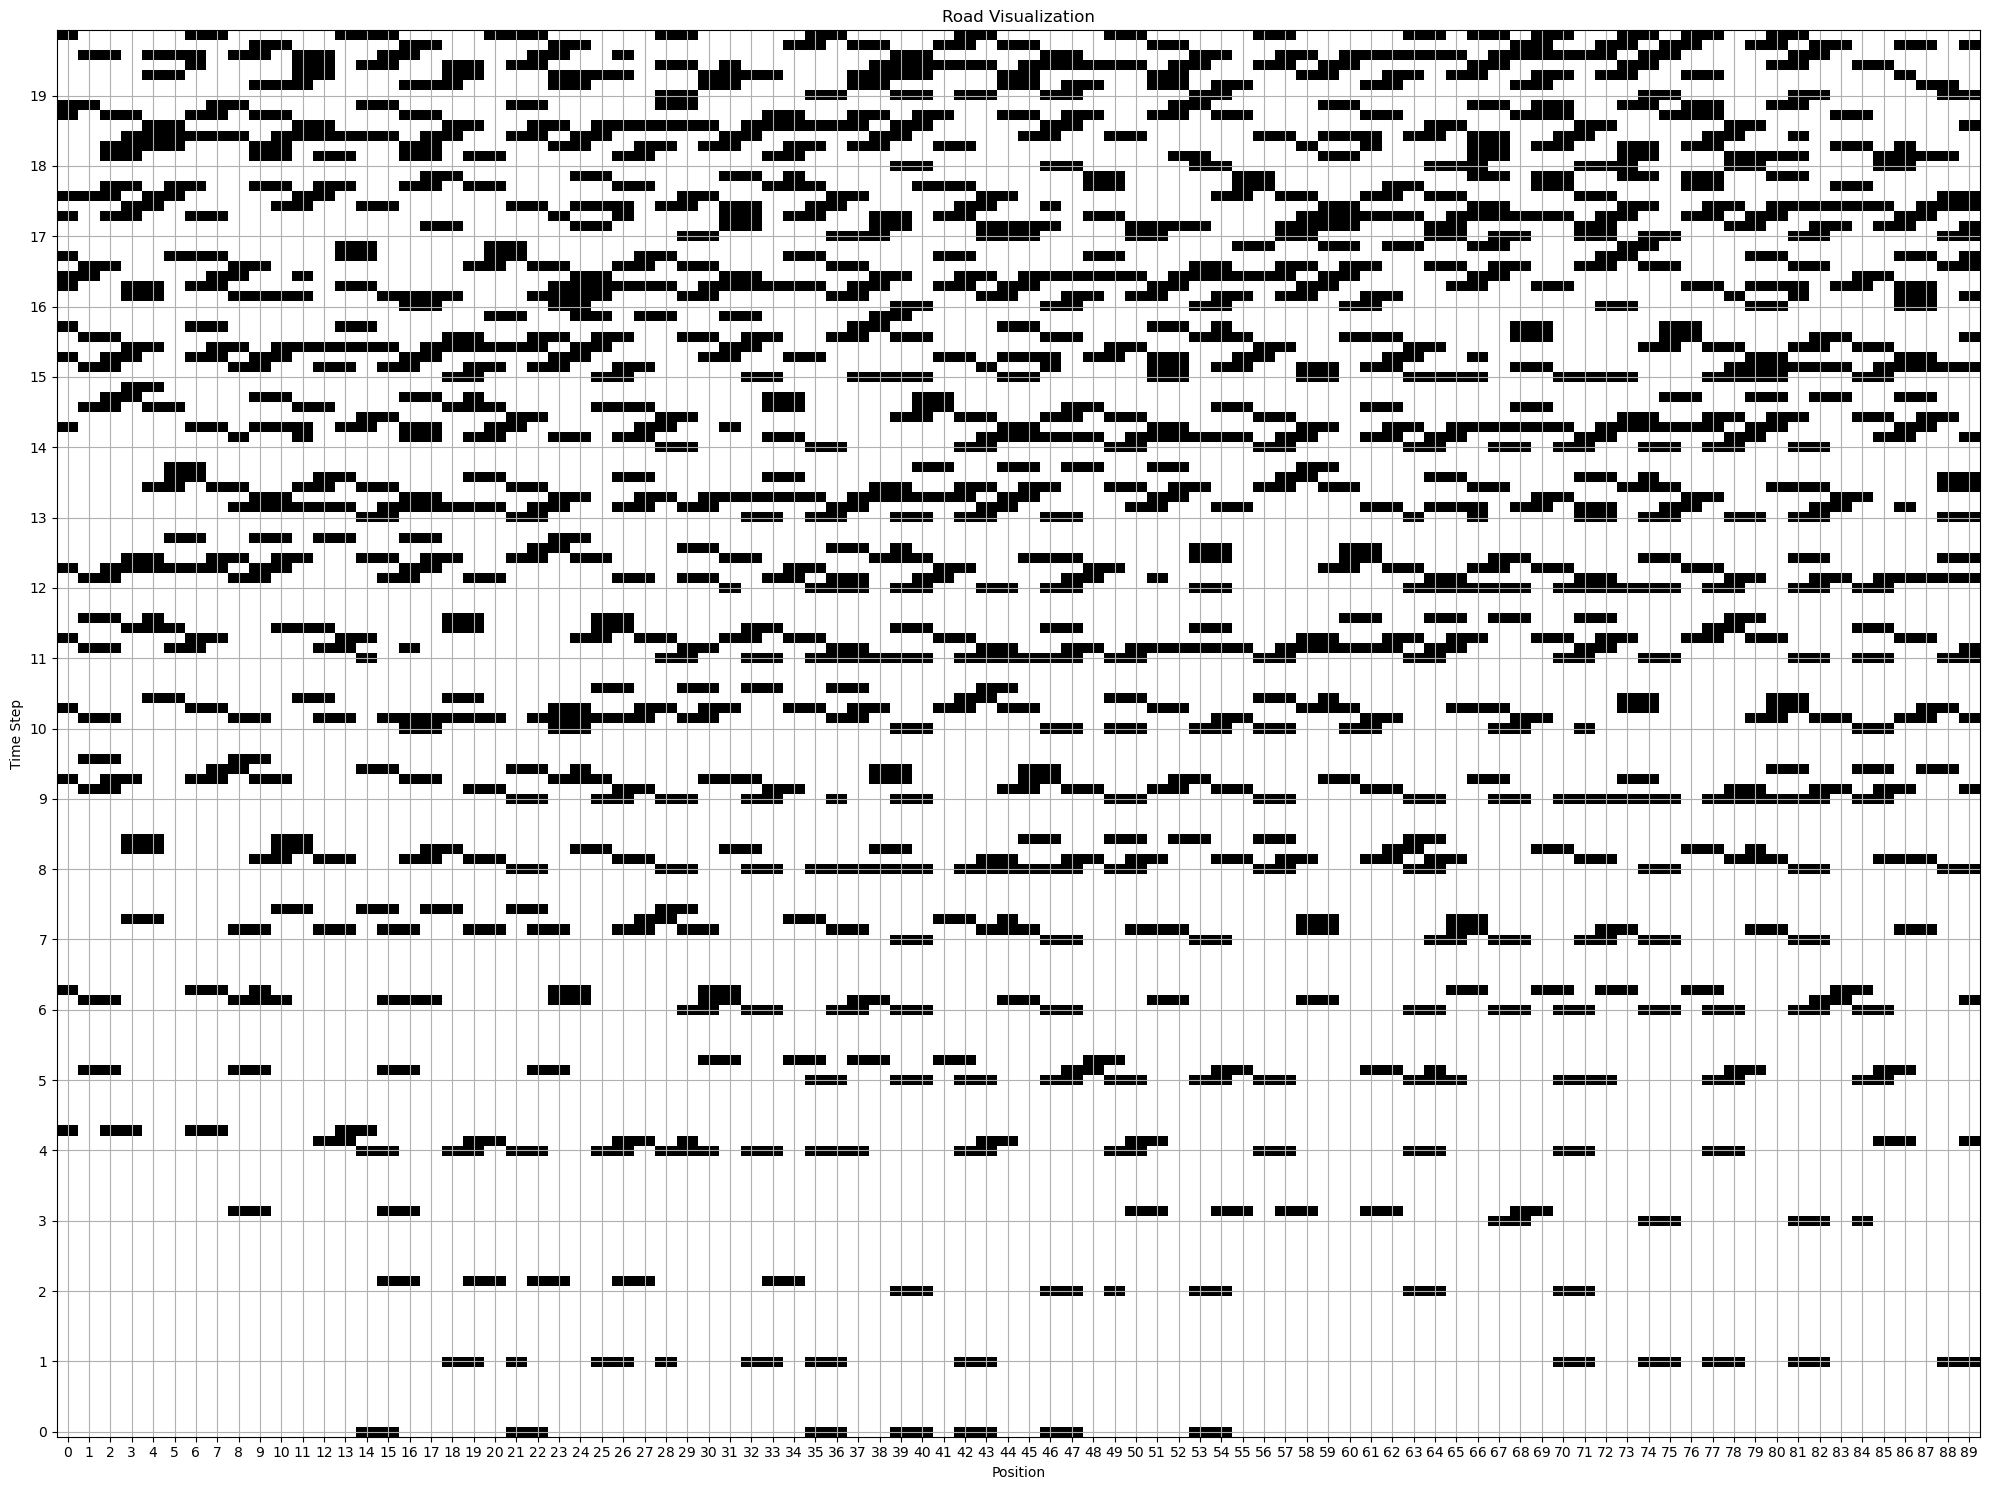

In [23]:
def visualize_road(occupancy_history):
    T = len(occupancy_history)
    road_length = occupancy_history[0].shape[0]
    road_width = occupancy_history[0].shape[1]

    road_states = np.array(occupancy_history).reshape((T * road_width, road_length))

    plt.figure(figsize=(20, 15))
    plt.imshow(road_states, cmap='binary', aspect='auto', origin='lower')
    plt.xticks(range(0, road_length, 1))
    plt.yticks(range(0, T * road_width, road_width), range(0, T))
    plt.xlabel('Position')
    plt.ylabel('Time Step')
    plt.title('Road Visualization')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Define the road
road = Road(road_length=90, road_width=7, speed_limit=5)
# Create the simulator
simulator = IntraRoadSimulator(road)
# Run the simulation
for _ in range(20):
    simulator.update()
# Visualize the road
visualize_road(simulator.occupancy_history)

The following contents are just testers

In [ ]:
   """def visualize_road(self, T): #just for sanity check
    # Initialize a 3D array to hold the state of the road at each timestep.
        road_states = np.zeros((T, self.road.road_length, self.road.road_width))
    
        for timestep in range(T):
            self.update()
            for vehicle in self.vehicles:
                for j in range(vehicle.length):
                    if vehicle.x_position + j < self.road.road_length:
                        road_states[timestep, vehicle.x_position + j, vehicle.current_lane:vehicle.current_lane + vehicle.width] = 1
    
    # Reshape road_states to stack the road width dimension for each timestep
        road_states = road_states.reshape((T * self.road.road_width, self.road.road_length))

    # Create the plot
        plt.figure(figsize=(12, 8))
        plt.imshow(road_states, cmap='binary', aspect='auto', origin='lower')
        plt.xticks(range(0, self.road.road_length, 1))
        plt.yticks(range(0, T * self.road.road_width, self.road.road_width), range(1, T + 1))
        plt.xlabel('Position')
        plt.ylabel('Time Step')
        plt.title('Road Visualization')
        plt.show()"""

In [80]:
?range

Init signature: range(self, /, *args, **kwargs)
Docstring:     
range(stop) -> range object
range(start, stop[, step]) -> range object

Return an object that produces a sequence of integers from start (inclusive)
to stop (exclusive) by step.  range(i, j) produces i, i+1, i+2, ..., j-1.
start defaults to 0, and stop is omitted!  range(4) produces 0, 1, 2, 3.
These are exactly the valid indices for a list of 4 elements.
When step is given, it specifies the increment (or decrement).
Type:           type
Subclasses:     

In [83]:
for i in range(4):
    print(i)

0
1
2
3


In [88]:
t = range(4)

In [96]:
np.random.choice(t)

0

Visualization tester

In [120]:
import numpy as np
import matplotlib.pyplot as plt
road_length = 10
road_width = 7
road_occupancy = np.zeros((road_length, road_width))
road_occupancy[1:3, 2:3]=1
print(road_occupancy.T) #get the transpose para ma-visualize horizontally properly

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


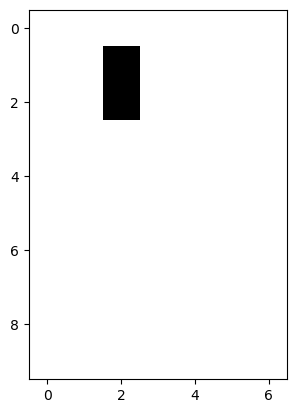

In [121]:
plt.imshow(road_occupancy, cmap='binary')

In [105]:
np.random.randint(1, road.speed_limit + 1)

2

In [ ]:
def produce_PUV(self):
    """Produce a public utility vehicle (jeep or minibus) and place it on the road."""
    vehicle_type = None
    vehicle_length = 0
    vehicle_width = 0
    current_lane = 0
    lane_changing_prob = 0

    # Define PUV lane
    PUV_lane = 4
    
    if np.random.rand() < self.jeep_production_prob:
        vehicle_type = 'jeep'
        vehicle_length = 3
        vehicle_width = 2
        lane_changing_prob = 0
    elif np.random.rand() < self.minibus_production_prob:
        vehicle_type = 'minibus'
        vehicle_length = 4
        vehicle_width = 2
        lane_changing_prob = 0
    else:
        # No vehicle produced this timestep
        return

    current_lane = PUV_lane  # PUVs are always placed in lane 4

    # Check if there is space for the vehicle on the lane
    road_portion_checked = self.road.road_occupancy[0:vehicle_length, current_lane:current_lane + vehicle_width]
    if np.sum(road_portion_checked) == 0:
        # Create a new vehicle and add it to the road
        new_vehicle_speed = np.random.randint(1, self.road.speed_limit + 1)
        new_vehicle = Vehicle(0, new_vehicle_speed, self.road.speed_limit, vehicle_length, vehicle_width, self.road, vehicle_type, current_lane, lane_changing_prob)
        self.vehicles.append(new_vehicle)
        # Update the road occupancy to include the new vehicle
        self.road.road_occupancy[0:new_vehicle.length, current_lane:current_lane + new_vehicle.width] = 1
    else:
        pass  # No space available for the new vehicle
